In [1]:
import pandas as pd

from Chord import Chord
from Rule import Rule
from collections import defaultdict
import pitchtypes as pt
from probabilistic_model import ProbabilisticModel
from itertools import product
import torch 
from Environment import Environment
from Helpers import get_possible_intervals, get_qualities, get_possible_rhs_from_str, get_applicable_rules, evaluate_tree_from_dict
from TreeNode import TreeNode
from DQN import train_on_batch, ReplayBuffer, train_model, DQN, DQNWithTransformer
import numpy as np
import random

In [ ]:
data = pd.read_json('../eda/JazzHarmonyTreebank/treebank.json')
trees_data = data[data['trees'].notna()]['trees']
ccts = [x[0]['complete_constituent_tree'] for x in list(trees_data)]
tree_chord_data = list(data[data['trees'].notna()]['chords'])

In [3]:
p_model = ProbabilisticModel()
p_model.fit(ccts)

In [4]:
prob_dict = p_model.prob_dict
rules = [Rule.unhash(i) for i in prob_dict.keys()]
chords_dataset = list(data['chords'])
# chords_dataset = [chord for chord in chords_dataset if len(chord) <= 20]  

In [5]:
env = Environment(chords_dataset[5], rules, prob_dict)

In [6]:
env.get_state_tensor()[0].shape

torch.Size([1, 720])

In [7]:
env.get_state_tensor()[1].shape

torch.Size([1, 20, 36])

In [8]:
model = DQN(1440, 20, hidden_dim=1024)

In [9]:
full_data = tree_chord_data.copy()
full_data.extend(random.sample(chords_dataset,150))

In [10]:
len(full_data)

300

In [11]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(tree_chord_data, test_size=0.2, random_state=42)

In [12]:
train_model(model,train_data, prob_dict, rules, num_episodes=20000)

Episode 0 complete | Last loss: 3.4590
Episode 10 complete | Last loss: 1.7825
Episode 20 complete | Last loss: 1.2324
Episode 30 complete | Last loss: 1.8392
Episode 40 complete | Last loss: 1.4400
Episode 50 complete | Last loss: 1.5531
Episode 60 complete | Last loss: 1.3839
Episode 70 complete | Last loss: 2.0004
Episode 80 complete | Last loss: 2.2833
Episode 90 complete | Last loss: 2.6004
Episode 100 complete | Last loss: 1.6991
Episode 110 complete | Last loss: 2.2965
Episode 120 complete | Last loss: 1.9765
Episode 130 complete | Last loss: 2.0335
Episode 140 complete | Last loss: 1.5778
Episode 150 complete | Last loss: 1.9174
Episode 160 complete | Last loss: 2.3405
Episode 170 complete | Last loss: 1.8738
Episode 180 complete | Last loss: 1.7258
Episode 190 complete | Last loss: 1.2524
Episode 200 complete | Last loss: 1.2850
Episode 210 complete | Last loss: 1.4440
Episode 220 complete | Last loss: 1.6952
Episode 230 complete | Last loss: 2.5350
Episode 240 complete | Last

In [ ]:
import random
import numpy as np
from Chord import Chord
from TreeNode import TreeNode, create_parent_node, get_top_level_nodes
from Helpers import get_possible_intervals, get_qualities, get_possible_rhs_from_str, get_applicable_rules
from Rule import Rule
from Chord import Chord
from TreeNode import TreeNode, create_parent_node, get_top_level_nodes
import torch

class Environment:

    MAX_ACTIONS = 20
    MAX_CHORDS = 20

    def __init__(self, chord_sequence, rules, prob_dict):
        self.initial_sequence = chord_sequence
        self.current_state = chord_sequence.copy()
        self.current_nodes = [TreeNode(Chord(chord)) for chord in chord_sequence]
        self.rules = rules
        self.prob_dict = prob_dict
        self.actions = self.get_actions()
        self.applied_rules = []
        
    # Each index of rhs are a list of applicable rules to currentstate and currentstate + 1
    def get_actions(self):
        rhs_list = []

        for i in range(len(self.current_state) - 1):
            chord1 = Chord(self.current_state[i])
            chord2 = Chord(self.current_state[i + 1])
            possible_rhs = get_possible_rhs_from_str(chord1, chord2)
            rhs_list.append(get_applicable_rules(possible_rhs, self.rules))


        return rhs_list
    
    def concat_state_and_actions(self, chords_tensor, actions_tensor):
        # Concatenate along the last dimension
        return torch.cat((chords_tensor.reshape(-1), actions_tensor.squeeze(0).reshape(-1)), dim=-1)


    def build_action_index_map(self):

        index_map = []
        for i, rule_list in enumerate(self.get_actions()):
            for j, _ in enumerate(rule_list):
                index_map.append((i, j))
        return index_map

    def apply_rule_index(self,rule_index_i,rule_index_j):
        rule = self.actions[rule_index_i][rule_index_j]
        node1 = self.current_nodes[rule_index_i]
        node2 = self.current_nodes[rule_index_i + 1]
        nodes = [node1,node2]
        parent_root_index = rule.child_intervals.index('0') 
        parent = create_parent_node(node1, node2, nodes[parent_root_index], rule.lhs())
        self.current_nodes[rule_index_i] = parent
        self.current_nodes.pop(rule_index_i + 1)
        self.applied_rules.append(rule)
        self.current_nodes = get_top_level_nodes(self.current_nodes)
        self.current_state = [node.chord.label for node in self.current_nodes]
        self.actions = self.get_actions()

    def apply_rule(self, rule, node1, node2):
        nodes = [node1,node2]
        parent_root_index = rule.child_intervals.index('0') 
        parent = create_parent_node(node1, node2, nodes[parent_root_index], rule.lhs())

        self.current_nodes.append(parent)
        self.applied_rules.append(rule)

        self.current_nodes = get_top_level_nodes(self.current_nodes)
        self.current_state = [node.chord.label for node in self.current_nodes]
        self.actions = self.get_actions()

    def get_state_tensor2(self):
        QUALITY_VOCAB = ['major', 'minor', 'sus', 'unknown']
        INTERVAL_VOCAB = [str(i) for i in range(0,12)]

        def one_hot_encode(value, vocab):
            vec = [0] * len(vocab)
            idx = vocab.index(value if value in vocab else vocab.index('Other'))
            vec[idx] = 1
            return vec

        def encode_rule(rule):
            parent_vec = one_hot_encode(rule.parent_quality, QUALITY_VOCAB)

            interval1_vec = one_hot_encode(rule.child_intervals[0], INTERVAL_VOCAB)
            quality1_vec = one_hot_encode(rule.child_qualities[0], QUALITY_VOCAB)

            interval2_vec = one_hot_encode(rule.child_intervals[1], INTERVAL_VOCAB)
            quality2_vec = one_hot_encode(rule.child_qualities[1], QUALITY_VOCAB)

            return parent_vec + interval1_vec + quality1_vec + interval2_vec + quality2_vec

        chord_vector = []
        for chord in self.current_state[:self.MAX_CHORDS]:
            chord_vector.append(Chord.encode_chord(chord))

        # Pad if needed
        while len(chord_vector) < self.MAX_CHORDS:
            chord_vector.append([0] * len(chord_vector[0]))

        flat_chord_vector = [val for chord in chord_vector for val in chord]
        # chord_tensor = torch.tensor(flat_chord_vector, dtype=torch.float32).unsqueeze(0)

        actions = self.get_actions()
        action_vector = []

        count = 0
        for i in range(len(actions)):
            for j in range(len(actions[i])):
                if count >= self.MAX_ACTIONS:
                    break
                action_vector.append(encode_rule(actions[i][j]))
                count += 1
            if count >= self.MAX_ACTIONS:
                break
        
        flat_action_vector = [val for action in action_vector for val in action]

        return torch.tensor(flat_chord_vector + flat_action_vector, dtype=torch.float32)
        # rule_dim = len(action_vector[0]) if action_vector else 0
        # while len(action_vector) < self.MAX_ACTIONS:
        #     action_vector.append([0] * rule_dim)

        # actions_tensor = torch.tensor(action_vector, dtype=torch.float32).unsqueeze(0)
        # return chord_tensor, actions_tensor


    def get_state_tensor(self):
        QUALITY_VOCAB = ['major', 'minor', 'sus', 'unknown']
        INTERVAL_VOCAB = [str(i) for i in range(0,12)]

        def one_hot_encode(value, vocab):
            vec = [0] * len(vocab)
            idx = vocab.index(value if value in vocab else vocab.index('Other'))
            vec[idx] = 1
            return vec

        def encode_rule(rule):
            parent_vec = one_hot_encode(rule.parent_quality, QUALITY_VOCAB)

            interval1_vec = one_hot_encode(rule.child_intervals[0], INTERVAL_VOCAB)
            quality1_vec = one_hot_encode(rule.child_qualities[0], QUALITY_VOCAB)

            interval2_vec = one_hot_encode(rule.child_intervals[1], INTERVAL_VOCAB)
            quality2_vec = one_hot_encode(rule.child_qualities[1], QUALITY_VOCAB)

            return parent_vec + interval1_vec + quality1_vec + interval2_vec + quality2_vec

        chord_vector = []
        for chord in self.current_state[:self.MAX_CHORDS]:
            chord_vector.append(Chord.encode_chord(chord))
            distance_vec = []
            for other_chord in self.current_state[:self.MAX_CHORDS]:
                distance = Chord(chord).distance_to(Chord(other_chord))
                distance_vec.append(distance)
            while len(distance_vec) < self.MAX_CHORDS:
                distance_vec.append(-1)
            chord_vector[-1].extend(distance_vec)
        # Pad if needed
        while len(chord_vector) < self.MAX_CHORDS:
            chord_vector.append([0] * len(chord_vector[0]))

        flat_chord_vector = [val for chord in chord_vector for val in chord]
        chord_tensor = torch.tensor(flat_chord_vector, dtype=torch.float32).unsqueeze(0)

        actions = self.actions
        action_vector = []

        count = 0
        for i in range(len(actions)):
            for j in range(len(actions[i])):
                if count >= self.MAX_ACTIONS:
                    break
                action_vector.append(encode_rule(actions[i][j]))
                count += 1
            if count >= self.MAX_ACTIONS:
                break

        rule_dim = len(action_vector[0]) if action_vector else 0
        while len(action_vector) < self.MAX_ACTIONS:
            action_vector.append([0] * rule_dim)

        actions_tensor = torch.tensor(action_vector, dtype=torch.float32).unsqueeze(0)
        return chord_tensor, actions_tensor

    def step_nn(self):
        chord_tensor, actions_tensor = self.get_state_tensor()
        model_input = self.concat_state_and_actions(chord_tensor, actions_tensor)
        results = self.model.forward(model_input)
        index_map = self.build_action_index_map()[0:self.MAX_ACTIONS]
        # print(len(index_map))
        if len(index_map) == 0:
            return None  # no actions possible
        
        q_values = self.model(model_input).detach().squeeze(0)[0:len(index_map)]  # shape: (num_actions,)
        flat_index = q_values.squeeze(0).argmax().item()

        # reward_before = self.evaluate_tree()
        i, j = index_map[flat_index]
        reward_before = self.evaluate_tree()
        self.apply_rule_index(i, j)
        reward_after = self.evaluate_tree()
        # reward_after = self.evaluate_tree()
        last_rule = self.applied_rules[-1]
        # reward = prob_dict.get(last_rule.make_hashable(), 1e-10)  # Use same small value as in evaluate_tree
        # delta_reward = reward_after - reward_before
        next_chord_tensor, next_actions_tensor = self.get_state_tensor()
        # reward = self.evaluate_tree() if self.is_terminal() else np.log(prob_dict.get(last_rule.make_hashable(), 1e-10))
        reward = self.evaluate_tree() if self.is_terminal() else np.log(self.prob_dict.get(last_rule.make_hashable(), 1e-10))
        # reward = reward_after - reward_before
        done = self.is_terminal()
        self.actions = self.get_actions()
        # if done:
        #     delta_reward = self.evaluate_tree()
        return {
        "state": chord_tensor,
        "actions": actions_tensor,
        "action_index": flat_index,
        "reward": reward,
        "next_state": next_chord_tensor,
        "next_actions": next_actions_tensor,
        "done": done
    }
    def step(self, epsilon=0.1):
        chord_tensor, actions_tensor = self.get_state_tensor()
        model_input = self.concat_state_and_actions(chord_tensor, actions_tensor)
        results = self.model.forward(model_input)
        index_map = self.build_action_index_map()[0:self.MAX_ACTIONS]
        # print(len(index_map))
        if len(index_map) == 0:
            return None  # no actions possible
        
        if random.random() < epsilon:
            flat_index = random.randint(0, len(index_map) - 1)
        else:
            q_values = self.model(model_input).detach().squeeze(0)[0:len(index_map)]  # shape: (num_actions,)
            flat_index = q_values.squeeze(0).argmax().item()

        # reward_before = self.evaluate_tree()
        i, j = index_map[flat_index]
        reward_before = self.evaluate_tree()
        self.apply_rule_index(i, j)
        reward_after = self.evaluate_tree()
        # reward_after = self.evaluate_tree()
        last_rule = self.applied_rules[-1]
        # reward = prob_dict.get(last_rule.make_hashable(), 1e-10)  # Use same small value as in evaluate_tree
        # delta_reward = reward_after - reward_before
        next_chord_tensor, next_actions_tensor = self.get_state_tensor()
        # reward = self.evaluate_tree() if self.is_terminal() else np.log(prob_dict.get(last_rule.make_hashable(), 1e-10))
        reward = self.evaluate_tree() if self.is_terminal() else np.log(self.prob_dict.get(last_rule.make_hashable(), 1e-10))
        # reward = reward_after - reward_before
        done = self.is_terminal()
        self.actions = self.get_actions()
        # if done:
        #     delta_reward = self.evaluate_tree()
        return {
        "state": chord_tensor,
        "actions": actions_tensor,
        "action_index": flat_index,
        "reward": reward,
        "next_state": next_chord_tensor,
        "next_actions": next_actions_tensor,
        "done": done
    }
    

    def nn_simulate(self, epsilon=0.1):
        while not self.is_terminal():
            result = self.step_nn()
            if result is None:
                break
 

    def add_model(self, model):
        self.model = model

    def is_terminal(self):
        return len(self.current_state) == 1

    def random_baseline_step(self):
        chord_tensor, actions_tensor = self.get_state_tensor()
        index_map = self.build_action_index_map()

        if len(index_map) == 0:
            return None
        flat_index = random.randint(0, len(index_map) - 1)
        i, j = index_map[flat_index]                
        self.apply_rule_index(i, j)

    def simulate_random_baseline(self):
        while not self.is_terminal():
            self.random_baseline_step()

    def simulate_greedy_baseline(self):
        while not self.is_terminal():
            actions = self.get_actions()
            index_map = self.build_action_index_map()
            max_prob = float('-inf')
            max_i = 0
            max_j = 0
            for i, rule_list in enumerate(actions):
                for j, rule in enumerate(rule_list):
                    prob = self.prob_dict.get(rule.make_hashable(), 1e-10)  # Use same small value as in evaluate_tree
                    if prob > max_prob:
                        max_prob = prob
                        max_i = i
                        max_j = j
            if len(index_map) == 0:
                break
            self.apply_rule_index(max_i, max_j)

    def evaluate_tree(self):
        log_probs = 0
        for rule in self.applied_rules:
            log_probs += np.log(self.prob_dict.get(rule.make_hashable(), 1e-10))  # Add a small value to avoid log(0)

        return log_probs 



In [71]:
test_env = Environment(chords_dataset[3], rules, prob_dict)
test_env.add_model(model)
test_env.nn_simulate()
test_env.evaluate_tree()

-16.38248864251163

In [75]:
chords_dataset[3]

['Bb7',
 'Eb7',
 'Bb7',
 'Bb7',
 'Eb7',
 'Ab7',
 'Bb7',
 'Bb7',
 'F7',
 'F7',
 'Bb7',
 'Bb7']

In [58]:
test_env.current_nodes

[TreeNode(label=Bb7)]

In [48]:
test_env.applied_rules

[Rule(parent_quality=major, child_intervals=['7', '0'], child_qualities=['major', 'major']),
 Rule(parent_quality=major, child_intervals=['0', '5'], child_qualities=['major', 'major']),
 Rule(parent_quality=major, child_intervals=['7', '0'], child_qualities=['major', 'major']),
 Rule(parent_quality=major, child_intervals=['0', '0'], child_qualities=['major', 'major']),
 Rule(parent_quality=major, child_intervals=['7', '0'], child_qualities=['major', 'major']),
 Rule(parent_quality=major, child_intervals=['0', '0'], child_qualities=['major', 'major']),
 Rule(parent_quality=major, child_intervals=['0', '0'], child_qualities=['major', 'major']),
 Rule(parent_quality=major, child_intervals=['10', '0'], child_qualities=['major', 'major']),
 Rule(parent_quality=major, child_intervals=['0', '0'], child_qualities=['major', 'major']),
 Rule(parent_quality=major, child_intervals=['0', '0'], child_qualities=['major', 'major']),
 Rule(parent_quality=major, child_intervals=['5', '0'], child_qualiti

In [69]:
test_env = Environment(chords_dataset[3], rules, prob_dict)
test_env.add_model(model)
test_env.simulate_greedy_baseline()
test_env.evaluate_tree()

-16.212803669722184

In [103]:
ccts_test = []
for i in test_data:
    tree = data[(data['trees'].notna()) & (data['chords'].apply(lambda x: x == i))]['trees']
    if not tree.empty:
        ccts_test.append(evaluate_tree_from_dict(list(tree)[0][0]['complete_constituent_tree'], prob_dict)[1])
    else:
        print(f"No tree found for chords: {i}")

In [104]:
ccts_test

[-55.03882200482483,
 -23.425272538096124,
 -56.18680747965747,
 -54.60884168014409,
 -61.29061865267092,
 -29.154677574812084,
 -40.05033578772051,
 -60.278744251739006,
 -57.58794902178626,
 -52.22006380413355,
 -69.53242534645604,
 -30.31343003945235,
 -39.96150857794829,
 -38.92989545412063,
 -18.075772325096086,
 -40.088218377685685,
 -47.7738189347266,
 -43.958065008645875,
 -44.22002731106609,
 -70.86627918209253,
 -27.94738817194612,
 -67.56832232177426,
 -27.891519388340573,
 -77.82401833150239,
 -59.391908248224226,
 -69.36053527811951,
 -92.99267399554375,
 -64.40927044544951,
 -35.26973544007929,
 -33.904837436530485]

In [88]:
ccts_test

[[{'open_constituent_tree': {'label': 'Fm7',
    'children': [{'label': 'Fm7',
      'children': [{'label': 'Fm6', 'children': []},
       {'label': 'Fm7',
        'children': [{'label': 'Gb7',
          'children': [{'label': 'Bbm6',
            'children': [{'label': 'F7',
              'children': [{'label': 'C7',
                'children': [{'label': 'G7',
                  'children': [{'label': 'D7', 'children': []},
                   {'label': 'G7', 'children': []}]},
                 {'label': 'C7', 'children': []}]},
               {'label': 'F7',
                'children': [{'label': 'Ab7',
                  'children': [{'label': 'Ebm7', 'children': []},
                   {'label': 'Ab7', 'children': []}]},
                 {'label': 'F7',
                  'children': [{'label': 'Cm7', 'children': []},
                   {'label': 'F7', 'children': []}]}]}]},
             {'label': 'Bbm6', 'children': []}]},
           {'label': 'Gb7',
            'children': [{'label':

In [76]:
data[data['trees'].notna()]

,title,measures,beats,chords,composers,year,meter,key,turnaround,trees,comments
1,Red Clay,"[1, 2, 3, 3, 4, 4, 5, 6, 6, 7, 8, 8]","[1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3]","[Cm7, Bbm7, Dbsus, Ebsus, Fsus, Gsus, Cm7, Bbm...","Hubbard, Freddie",1970,"{'numerator': 4, 'denominator': 4}",c,-1.0,"[{'open_constituent_tree': {'label': 'Cm7', 'c...",NaN
9,Equinox,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[C#m7, C#m7, C#m7, C#m7, F#m7, F#m7, C#m7, C#m...","Coltrane, John",1960,"{'numerator': 4, 'denominator': 4}",c#,NaN,"[{'open_constituent_tree': {'label': 'C#m7', '...",NaN
10,"Jody Grind, The","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[Bbm7, Bbm7, Bbm7, Bbm7, Eb7, Eb7, Bbm7, Bbm7,...","Silver, Horace",1966,"{'numerator': 4, 'denominator': 4}",b-,NaN,"[{'open_constituent_tree': {'label': 'Bbm7', '...",NaN
14,Mr. P.C.,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[Cm7, Cm7, Cm7, Cm7, Fm7, Fm7, Cm7, Cm7, Ab7, ...","Coltrane, John",1959,"{'numerator': 4, 'denominator': 4}",c,0.0,"[{'open_constituent_tree': {'label': 'Cm7', 'c...",NaN
21,Blues For Wood,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11, 12]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1]","[Fm7, Fm7, Fm7, Fm7, Db7, Db7, Fm7, Fm7, Db7, ...","Shaw, Woody",1976,"{'numerator': 4, 'denominator': 4}",f,NaN,"[{'open_constituent_tree': {'label': 'Fm7', 'c...",NaN
...,...,...,...,...,...,...,...,...,...,...,...
294,Don't Worry 'Bout Me,"[1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, 12,...","[1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 4, ...","[Bbm7, Eb7, Ab^7, Ab^7, Bbm7, Eb7, Ab6, Cm7, B...","Bloom, Rube",1939,"{'numerator': 4, 'denominator': 4}",A-,2.0,"[{'open_constituent_tree': {'label': 'Ab6', 'c...",NaN
295,Exactly Like You,"[1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, 13,...","[1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, ...","[C6, C6, D7, D7, G7, G7, C6, Dm7, G7, C6, C6, ...","McHugh, Jimmy",1930,"{'numerator': 4, 'denominator': 4}",C,2.0,"[{'open_constituent_tree': {'label': 'C6', 'ch...",NaN
298,I've Found A New Baby,"[1, 2, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 10, 11, ...","[1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, ...","[Dm7, E%7, A7, Dm7, D7, G7, C7, F^7, E%7, A7, ...","Palmer, Jack & Williams, Spencer",1926,"{'numerator': 4, 'denominator': 4}",F,0.0,"[{'open_constituent_tree': {'label': 'F^7', 'c...",NaN
349,How High The Moon,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11, 12, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, ...","[G^7, G^7, Gm7, C7, F^7, F^7, Fm7, Bb7, Eb^7, ...","Lewis, Morgan",1940,"{'numerator': 4, 'denominator': 4}",G,NaN,"[{'open_constituent_tree': {'label': 'G6', 'ch...",Gm7 (G^7) in measure 3 of the B (C) part is no...


In [59]:
greedy = []
random_vals = []
nn_vals = []
counter = 0
for chord in test_data:
    counter += 1
    env = Environment(chord, rules, prob_dict)
    env.add_model(model)
    env.simulate_random_baseline()

    random_vals.append(env.evaluate_tree())
    env = Environment(chord, rules, prob_dict)
    env.add_model(model)
    env.simulate_greedy_baseline()
    greedy.append(env.evaluate_tree())
    
    env = Environment(chord, rules, prob_dict)
    env.add_model(model)
    env.nn_simulate()
    nn_vals.append(env.evaluate_tree())
    

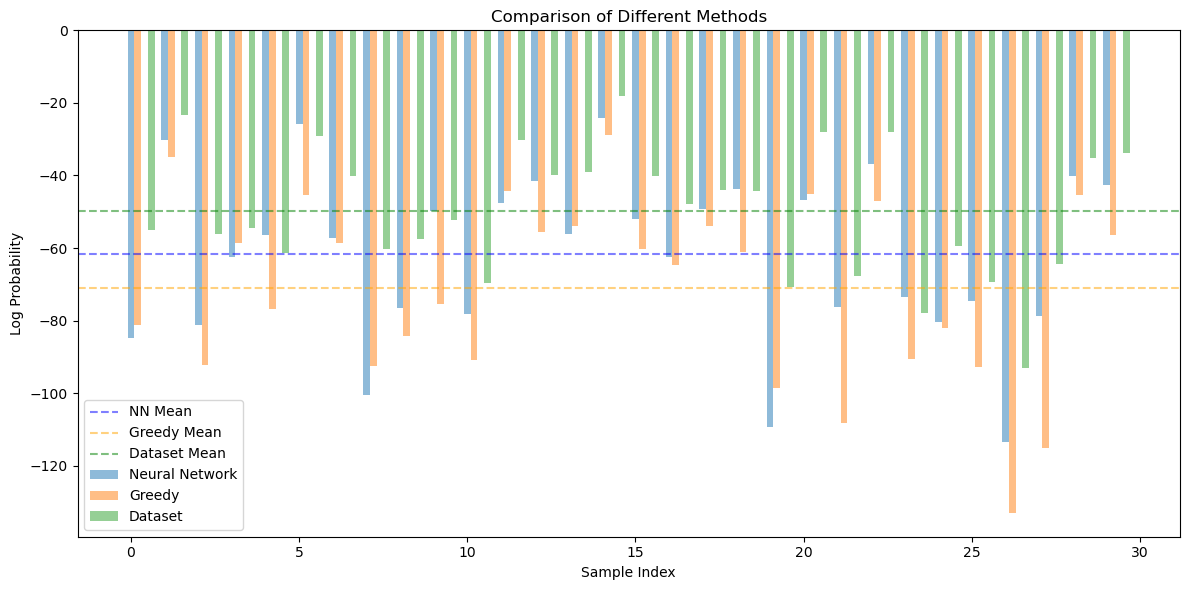

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
x = range(len(nn_vals))
plt.bar(x, nn_vals, alpha=0.5, label='Neural Network', width=0.2)
plt.bar([i+0.2 for i in x], greedy, alpha=0.5, label='Greedy', width=0.2)
plt.bar([i+0.6 for i in x], ccts_test, alpha=0.5, label='Dataset', width=0.2)
plt.xlabel('Sample Index')
plt.ylabel('Log Probability')
plt.title('Comparison of Different Methods')
plt.axhline(y=np.mean(nn_vals), color='blue', linestyle='--', alpha=0.5, label='NN Mean')
plt.axhline(y=np.mean(greedy), color='orange', linestyle='--', alpha=0.5, label='Greedy Mean')
plt.axhline(y=np.mean(ccts_test), color='green', linestyle='--', alpha=0.5, label='Dataset Mean')
plt.tight_layout()
plt.legend()
plt.show()

In [108]:
print("greedy",np.mean(greedy), "random",np.mean(random_vals), "nn", np.mean(nn_vals))

greedy -70.93052233737082 random -153.00770443839468 nn -61.763812063020296


In [ ]:
def evaluate_tree_from_dict(tree, prob_dict,parent_label=None):
    applied_rules = []
    log_probs = 0
    if tree.get('children'):
        children = tree['children']
        
        if len(children) == 2:
            chord1 = Chord(children[0]['label'])
            chord2 = Chord(children[1]['label'])
            parent = Chord(tree['label'])
            parent_quality = parent.quality

            if chord1.distance_to(parent) == 0:
                chord1interval = 0
                chord2interval = chord1.distance_to(chord2)
            elif chord2.distance_to(parent) == 0:
                chord1interval = chord2.distance_to(chord1)
                chord2interval = 0
            else:
                # If neither child matches the parent, use distance from parent
                chord1interval = chord1.distance_to(parent)
                chord2interval = chord2.distance_to(parent)

            child_intervals = [str(chord1interval), str(chord2interval)]
            child_qualities = [chord1.quality, chord2.quality]

            rule = Rule(parent_quality, child_intervals, child_qualities)
            applied_rules.append(rule)

        # Recursively gather rules from children
        for child in children:
            applied_rules.extend(evaluate_tree_from_dict(child, prob_dict,tree['label'])[0])

    for rule in applied_rules:
        rule_hash = rule.make_hashable()
        if rule_hash in prob_dict:
            log_probs += np.log(prob_dict[rule_hash])
        else:
            log_probs += np.log(1e-10)
    return applied_rules, log_probs


In [ ]:
for i in 

In [ ]:
test_index = 10

In [ ]:
a = evaluate_tree_from_dict(ccts[0], prob_dict)

In [ ]:
a

([Rule(parent_quality=minor, child_intervals=['0', '0'], child_qualities=['minor', 'minor']),
  Rule(parent_quality=minor, child_intervals=['7', '0'], child_qualities=['sus', 'minor']),
  Rule(parent_quality=sus, child_intervals=['10', '0'], child_qualities=['sus', 'sus']),
  Rule(parent_quality=sus, child_intervals=['10', '0'], child_qualities=['sus', 'sus']),
  Rule(parent_quality=sus, child_intervals=['7', '0'], child_qualities=['minor', 'sus']),
  Rule(parent_quality=sus, child_intervals=['10', '0'], child_qualities=['sus', 'sus']),
  Rule(parent_quality=minor, child_intervals=['0', '0'], child_qualities=['minor', 'minor']),
  Rule(parent_quality=minor, child_intervals=['7', '0'], child_qualities=['major', 'minor']),
  Rule(parent_quality=major, child_intervals=['1', '0'], child_qualities=['major', 'major']),
  Rule(parent_quality=major, child_intervals=['7', '0'], child_qualities=['major', 'major']),
  Rule(parent_quality=major, child_intervals=['7', '0'], child_qualities=['minor'

In [ ]:
log_probs = 0
for rule in a:
    log_probs += np.log(prob_dict.get(rule.make_hashable(), 1e-10))  # Add a small value to avoid log(0)

In [ ]:
log_probs

-15.346407963850615

In [ ]:
trees_data

1       [{'open_constituent_tree': {'label': 'Cm7', 'c...
9       [{'open_constituent_tree': {'label': 'C#m7', '...
10      [{'open_constituent_tree': {'label': 'Bbm7', '...
14      [{'open_constituent_tree': {'label': 'Cm7', 'c...
21      [{'open_constituent_tree': {'label': 'Fm7', 'c...
                              ...                        
294     [{'open_constituent_tree': {'label': 'Ab6', 'c...
295     [{'open_constituent_tree': {'label': 'C6', 'ch...
298     [{'open_constituent_tree': {'label': 'F^7', 'c...
349     [{'open_constituent_tree': {'label': 'G6', 'ch...
1047    [{'open_constituent_tree': {'label': 'C6', 'ch...
Name: trees, Length: 150, dtype: object

In [ ]:
data = pd.read_json('../eda/JazzHarmonyTreebank/treebank.json')
tree_chord_data = data[data['trees'].notna()]


In [ ]:
test_chords = tree_chord_data['chords'].to_list()[test_index]

In [ ]:
evaluate_tree_from_dict(ccts[test_index],prob_dict)[1]

-22.286634687293137

In [ ]:
test_env = Environment(test_chords)
test_env.add_model(model)
test_env.simulate_random_baseline()
test_env.evaluate_tree()

-88.19316561630309

In [ ]:
test_env = Environment(test_chords)
test_env.add_model(model)
test_env.simulate_greedy_baseline()
test_env.evaluate_tree()

-21.16685169150206